In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr

import torch
import torch.nn as nn
import joblib

In [2]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [102]:
#mid = "100pct_3day-removed" #potential
mid = "y-cond-3day" #conducvity
target = 'conductivity'
path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{mid}_outputs"

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [104]:
model = MLP(10)
model.load_state_dict(torch.load(f'{path}/model_{mid}.pt'))
model.eval()
#model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [105]:
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path_reppu = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/xbig5min.dat' #Server

#read the REPPU data
with open (path_reppu) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

reppu_data = reppu_data.reshape(-1,30, 80)
reppu_data.shape

(45792, 30, 80)

In [106]:
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
    for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [107]:
time_res = 5

if time_res == 1:
    time_step = 1440
else :
    time_step = 288

In [108]:
data_reshaped = reppu_data.reshape(len(expanded_dt), time_step, 30, 80) 

# Define coordinates
time = np.arange(time_step)
lat = np.linspace(50, 90, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1, 360, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*time_res))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({target: (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
        coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
#ds['potential'].attrs['units'] = 'kV'
#ds[target] = ds[target] * 1e-3 # Convert to kV
ds

<xarray.Dataset> Size: 440MB
Dimensions:       (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt            (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat           (lat) float64 240B 50.0 51.38 52.76 54.14 ... 87.24 88.62 90.0
  * lon           (lon) float64 640B 1.0 5.544 10.09 14.63 ... 350.9 355.5 360.0
Data variables:
    conductivity  (dt, lat, lon) float32 440MB 1.845 1.845 1.845 ... 4.887 4.885

In [109]:
omni_df = pd.read_csv('omni_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.ffill().bfill()
omni_df = omni_df.dropna() #drop any remaining NaNs

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='outer')
reppu_omni_ds['mlt'] = np.mod(reppu_omni_ds['lon'] / 15, 24)

#select date range
reppu_omni_ds = reppu_omni_ds.sortby('dt')
reppu_omni_ds

<xarray.Dataset> Size: 442MB
Dimensions:         (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-08-19T23:55:00
  * lat             (lat) float64 240B 50.0 51.38 52.76 ... 87.24 88.62 90.0
  * lon             (lon) float64 640B 1.0 5.544 10.09 ... 350.9 355.5 360.0
Data variables:
    conductivity    (dt, lat, lon) float32 440MB 1.845 1.845 ... 4.135 4.134
    BY_GSE          (dt) float64 366kB 4.72 4.35 4.61 4.65 ... -2.49 -2.04 -1.92
    BZ_GSE          (dt) float64 366kB 6.24 6.55 6.56 6.89 ... -4.47 -4.64 -4.5
    flow_speed      (dt) float64 366kB 344.0 344.0 345.0 ... 655.0 653.0 658.0
    proton_density  (dt) float64 366kB 12.11 11.44 12.65 ... 6.22 5.59 5.34
    tilt_angle      (dt) float64 366kB 0.253 0.2497 0.2465 ... 0.1769 0.1735
    mlt             (lon) float64 640B 0.06667 0.3696 0.6726 ... 23.39 23.7 0.0

In [110]:
#reppu_omni_ds = reppu_omni_ds.sel(dt=slice('2021-05-10 00:00:00', '2021-05-10 23:55:00')) #shock, moderate storm. R 0.06/1, Kp2
#reppu_omni_ds = reppu_omni_ds.sel(dt=slice('2021-10-11 00:00:00', '2021-10-11 23:55:00')) #shock event. R 0.65/1 Kp4-
reppu_omni_ds = reppu_omni_ds.sel(dt=slice('2022-01-30 00:00:00', '2022-01-30 23:55:00')) #shock event R 0.77/1 Kp3

#reppu_omni_ds = reppu_omni_ds.sel(dt=slice('2022-07-30 00:00:00', '2022-07-30 23:55:00')) #test slice (has seen during training)
reppu_omni_ds

<xarray.Dataset> Size: 3MB
Dimensions:         (dt: 288, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2kB 2022-01-30 ... 2022-01-30T23:55:00
  * lat             (lat) float64 240B 50.0 51.38 52.76 ... 87.24 88.62 90.0
  * lon             (lon) float64 640B 1.0 5.544 10.09 ... 350.9 355.5 360.0
Data variables:
    conductivity    (dt, lat, lon) float32 3MB 1.845 1.845 1.845 ... 1.621 1.621
    BY_GSE          (dt) float64 2kB 4.29 4.18 3.75 3.79 ... -2.13 -4.23 -3.96
    BZ_GSE          (dt) float64 2kB 1.31 -0.79 -2.39 ... -4.17 -2.87 -3.17
    flow_speed      (dt) float64 2kB 551.0 544.0 547.0 ... 478.0 472.0 477.0
    proton_density  (dt) float64 2kB 1.5 1.49 1.68 1.8 ... 1.73 1.68 1.17 1.25
    tilt_angle      (dt) float64 2kB -0.3445 -0.348 -0.3514 ... -0.3328 -0.3362
    mlt             (lon) float64 640B 0.06667 0.3696 0.6726 ... 23.39 23.7 0.0

In [111]:
def split_to_df(ds):
    ds = ds.copy()
    df = ds.to_dataframe().reset_index()

    df=df[['dt','mlt','lon','lat',target,'BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]

    df_2 = df.copy()

    df_2['mlt_sin'] = np.sin(df_2['mlt']*(2.*np.pi/24))
    df_2['mlt_cos'] = np.cos(df_2['mlt']*(2.*np.pi/24))

    df_2['lon_sin'] = np.sin((df_2['lon']-1)*(2.*np.pi/360))
    df_2['lon_cos'] = np.cos((df_2['lon']-1)*(2.*np.pi/360))

    df_2 = df_2.drop(columns=['dt', target])
    #df_2 = df_2.drop(columns=['dt', 'potential', 'lat', 'mlt_sin', 'mlt_cos', 'lon_sin', 'lon_cos'])

    return df, df_2

df_raw, df_proc = split_to_df(reppu_omni_ds)
df_raw

,dt,mlt,lon,lat,conductivity,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle
0,2022-01-30 00:00:00,0.066667,1.000000,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534
1,2022-01-30 00:00:00,0.369620,5.544304,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534
2,2022-01-30 00:00:00,0.672574,10.088608,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534
3,2022-01-30 00:00:00,0.975527,14.632911,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534
4,2022-01-30 00:00:00,1.278481,19.177215,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534
...,...,...,...,...,...,...,...,...,...,...
691195,2022-01-30 23:55:00,22.788186,341.822785,90.0,1.620935,-3.96,-3.17,477.0,1.25,-0.336227
691196,2022-01-30 23:55:00,23.091139,346.367089,90.0,1.620926,-3.96,-3.17,477.0,1.25,-0.336227
691197,2022-01-30 23:55:00,23.394093,350.911392,90.0,1.620916,-3.96,-3.17,477.0,1.25,-0.336227
691198,2022-01-30 23:55:00,23.697046,355.455696,90.0,1.620906,-3.96,-3.17,477.0,1.25,-0.336227


In [112]:
#with open(f'{path}/scaler_{mid}.pkl', 'rb') as f:
#    scaler = joblib.load(f)

with open(f'{path}/scaler_{mid}.pkl', 'rb') as f:
    scaler = pickle.load(f)

col_names = df_proc.columns
norm_arr = scaler.transform(df_proc)
df_proc = pd.DataFrame(norm_arr, columns=col_names)
df_proc = df_proc.drop(columns=['mlt','lon'])
df_proc

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


,lat,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,mlt_sin,mlt_cos,lon_sin,lon_cos
0,0.0,0.597018,0.512937,0.487365,0.020125,0.198681,0.508835,0.999924,0.499894,1.000000
1,0.0,0.597018,0.512937,0.487365,0.020125,0.198681,0.548429,0.997660,0.539522,0.998428
2,0.0,0.597018,0.512937,0.487365,0.020125,0.198681,0.587720,0.992267,0.578901,0.993721
3,0.0,0.597018,0.512937,0.487365,0.020125,0.198681,0.626460,0.983778,0.617784,0.985910
4,0.0,0.597018,0.512937,0.487365,0.020125,0.198681,0.664405,0.972247,0.655925,0.975042
...,...,...,...,...,...,...,...,...,...,...
691195,1.0,0.423772,0.420203,0.353791,0.016313,0.205951,0.344075,0.975042,0.335595,0.972247
691196,1.0,0.423772,0.420203,0.353791,0.016313,0.205951,0.382216,0.985910,0.373540,0.983778
691197,1.0,0.423772,0.420203,0.353791,0.016313,0.205951,0.421099,0.993721,0.412280,0.992267
691198,1.0,0.423772,0.420203,0.353791,0.016313,0.205951,0.460478,0.998428,0.451571,0.997660


In [113]:
df_proc = df_proc.to_numpy()
df_proc = torch.tensor(df_proc, dtype=torch.float32)

batch_size = 10000  # Adjust this value based on your system's memory capacity
n = len(df_proc)
predictions = []

for i in range(0, n, batch_size):
    batch = df_proc[i:i+batch_size]
    batch_pred = model(batch).detach().cpu().numpy()
    batch_pred = batch_pred.flatten()
    predictions.extend(batch_pred)

df_raw[f'{target}_pred'] = predictions
df_comp = df_raw
df_comp

,dt,mlt,lon,lat,conductivity,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,conductivity_pred
0,2022-01-30 00:00:00,0.066667,1.000000,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534,1.623072
1,2022-01-30 00:00:00,0.369620,5.544304,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534,1.623072
2,2022-01-30 00:00:00,0.672574,10.088608,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534,1.624136
3,2022-01-30 00:00:00,0.975527,14.632911,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534,1.623073
4,2022-01-30 00:00:00,1.278481,19.177215,50.0,1.844761,4.29,1.31,551.0,1.50,-0.344534,1.623073
...,...,...,...,...,...,...,...,...,...,...,...
691195,2022-01-30 23:55:00,22.788186,341.822785,90.0,1.620935,-3.96,-3.17,477.0,1.25,-0.336227,1.622310
691196,2022-01-30 23:55:00,23.091139,346.367089,90.0,1.620926,-3.96,-3.17,477.0,1.25,-0.336227,1.622518
691197,2022-01-30 23:55:00,23.394093,350.911392,90.0,1.620916,-3.96,-3.17,477.0,1.25,-0.336227,1.620746
691198,2022-01-30 23:55:00,23.697046,355.455696,90.0,1.620906,-3.96,-3.17,477.0,1.25,-0.336227,1.622554


<Axes: xlabel='conductivity', ylabel='Count'>

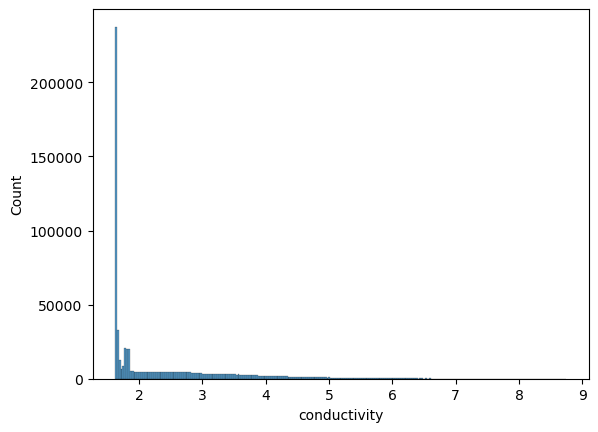

In [114]:
sns.histplot(df_comp['conductivity'])

In [115]:
diff_rmse = np.sqrt(np.mean((df_comp[target] - df_comp[f'{target}_pred'])**2))
diff_mae = np.mean(np.abs(df_comp[target] - df_comp[f'{target}_pred']))
diff_R = np.corrcoef(df_comp[target], df_comp[f'{target}_pred'])[0,1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill  
    
diff_skill = skill(df_comp[f'{target}_pred'], df_comp[target])

print(f'RMSE: {diff_rmse:.2f}')
print(f'MAE: {diff_mae:.2f}')
print(f'R: {diff_R:.2f}')
print(f'PE: {diff_skill:.2f}')

RMSE: 0.42
MAE: 0.24
R: 0.92
PE: 0.84


Convert to DS and plot panels with sliding window

In [116]:
def to_xr(df):
    df = df.copy()
    df['dt'] = pd.to_datetime(df['dt'])
    df = df.set_index(['dt', 'lat', 'lon'])
    ds = df.to_xarray()

    ds['mlt'] = ds['BY_GSE'].mean(dim=['lat', 'dt'])
    ds['BY_GSE'] = ds['BY_GSE'].mean(dim=['lat', 'lon'])
    ds['BZ_GSE'] = ds['BZ_GSE'].mean(dim=['lat', 'lon'])
    ds['flow_speed'] = ds['flow_speed'].mean(dim=['lat', 'lon'])
    ds['proton_density'] = ds['proton_density'].mean(dim=['lat', 'lon'])
    ds['tilt_angle'] = ds['tilt_angle'].mean(dim=['lat', 'lon'])
    
    return ds

ds_pred = to_xr(df_comp)
ds_pred

<xarray.Dataset> Size: 6MB
Dimensions:            (dt: 288, lat: 30, lon: 80)
Coordinates:
  * dt                 (dt) datetime64[ns] 2kB 2022-01-30 ... 2022-01-30T23:5...
  * lat                (lat) float64 240B 50.0 51.38 52.76 ... 87.24 88.62 90.0
  * lon                (lon) float64 640B 1.0 5.544 10.09 ... 350.9 355.5 360.0
Data variables:
    mlt                (lon) float64 640B 0.2886 0.2886 0.2886 ... 0.2886 0.2886
    conductivity       (dt, lat, lon) float32 3MB 1.845 1.845 ... 1.621 1.621
    BY_GSE             (dt) float64 2kB 4.29 4.18 3.75 ... -2.13 -4.23 -3.96
    BZ_GSE             (dt) float64 2kB 1.31 -0.79 -2.39 ... -4.17 -2.87 -3.17
    flow_speed         (dt) float64 2kB 551.0 544.0 547.0 ... 478.0 472.0 477.0
    proton_density     (dt) float64 2kB 1.5 1.49 1.68 1.8 ... 1.68 1.17 1.25
    tilt_angle         (dt) float64 2kB -0.3445 -0.348 ... -0.3328 -0.3362
    conductivity_pred  (dt, lat, lon) float32 3MB 1.623 1.623 ... 1.623 1.621

In [117]:
def clock_angle(By, Bz):
    angle = np.rad2deg(np.arctan2(By, Bz))
    angle[angle < 0] += 360
    return angle

def clock_length(By, Bz):
    return np.sqrt(By**2 + Bz**2)

def CPCP(Vsw, B, theta):
    #from https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/96JA01742
    #and  https://www.sws.bom.gov.au/Category/Solar/Solar%20Conditions/Solar%20Wind%20Clock%20Angle/Solar%20Wind%20Clock%20Angle.php
    return 10e-4 * Vsw**2 + 11.7 * B * (np.sin(np.deg2rad(theta)/2))**3

ds_pred['clock_angle'] = clock_angle(ds_pred['BY_GSE'], ds_pred['BZ_GSE'])
ds_pred['clock_length'] = clock_length(ds_pred['BY_GSE'], ds_pred['BZ_GSE'])
ds_pred['CPCP'] = CPCP(ds_pred['flow_speed'], ds_pred['clock_length'], ds_pred['clock_angle'])
ds_pred

<xarray.Dataset> Size: 6MB
Dimensions:            (dt: 288, lat: 30, lon: 80)
Coordinates:
  * dt                 (dt) datetime64[ns] 2kB 2022-01-30 ... 2022-01-30T23:5...
  * lat                (lat) float64 240B 50.0 51.38 52.76 ... 87.24 88.62 90.0
  * lon                (lon) float64 640B 1.0 5.544 10.09 ... 350.9 355.5 360.0
Data variables:
    mlt                (lon) float64 640B 0.2886 0.2886 0.2886 ... 0.2886 0.2886
    conductivity       (dt, lat, lon) float32 3MB 1.845 1.845 ... 1.621 1.621
    BY_GSE             (dt) float64 2kB 4.29 4.18 3.75 ... -2.13 -4.23 -3.96
    BZ_GSE             (dt) float64 2kB 1.31 -0.79 -2.39 ... -4.17 -2.87 -3.17
    flow_speed         (dt) float64 2kB 551.0 544.0 547.0 ... 478.0 472.0 477.0
    proton_density     (dt) float64 2kB 1.5 1.49 1.68 1.8 ... 1.68 1.17 1.25
    tilt_angle         (dt) float64 2kB -0.3445 -0.348 ... -0.3328 -0.3362
    conductivity_pred  (dt, lat, lon) float32 3MB 1.623 1.623 ... 1.623 1.621
    clock_angle        (dt) float64 2kB 73.02 100.7 122.5 ... 207.1 235.8 231.3
    clock_length       (dt) float64 2kB 4.486 4.254 4.447 ... 4.682 5.112 5.073
    CPCP               (dt) float64 2kB 314.7 318.7 334.3 ... 278.8 264.0 271.0

Potential

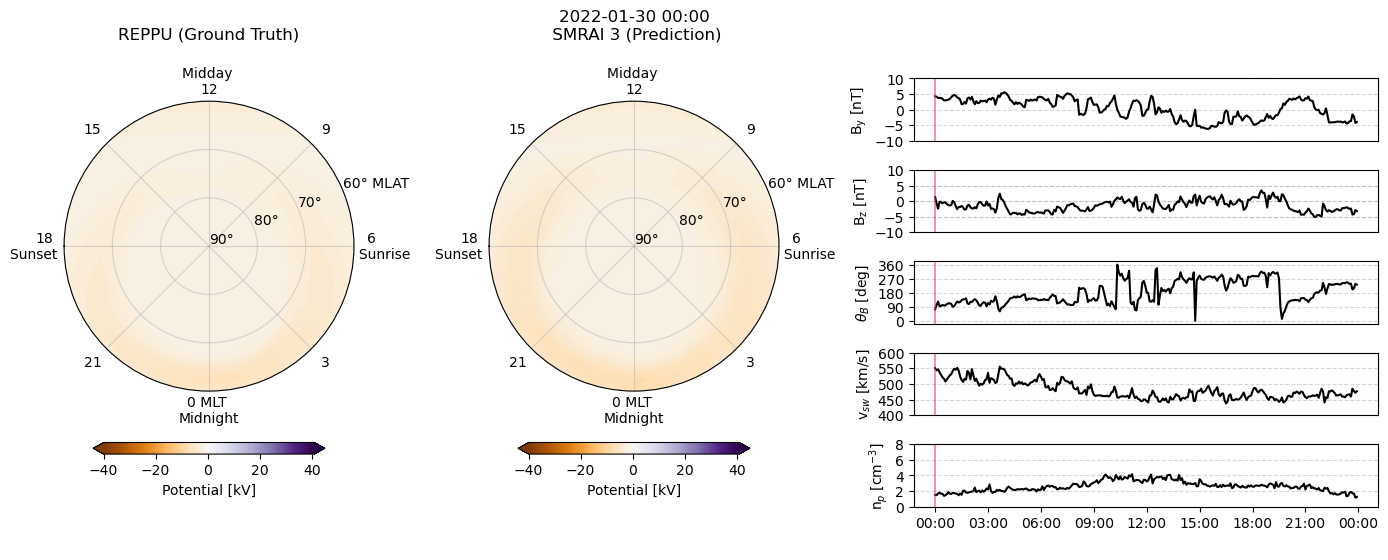

In [48]:
date = '2022-01-30'
#date = '2021-05-10'
time_plot = ds_pred.sel(dt=date)['dt']
times = ds_pred.sel(dt=date)['dt'].values
#remove the last time

#common paramters for ax1 (radar plot)
theta = np.linspace(0, 360, 80) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 30)

levels = np.linspace(-0.50, 0.50+0.01, 100)
shrink = 0.8
c_pad = 0.12
t_pad = 10

#current labels
ma = r'$\mathrm{\mu}$A/m$^{-2}$'
j_lab = r'J$_{||}$'
current_lab = f'FAC ({j_lab}) [{ma}]'


for i, time in enumerate(times):

    # Create a figure and GridSpec with 5 rows and 2 columns
    fig = plt.figure(figsize=(14, 5.5))
    
    gs = GridSpec(5, 3, width_ratios=[5, 5, 8])
    ax1 = fig.add_subplot(gs[:, 0], projection='polar') #make 1st column span all rows
    ax2 = fig.add_subplot(gs[:, 1], projection='polar') #make 1st column span all rows
    ax2_1 = fig.add_subplot(gs[0, 2])
    ax2_2 = fig.add_subplot(gs[1, 2], sharex=ax2_1)
    ax2_3 = fig.add_subplot(gs[2, 2], sharex=ax2_1)
    ax2_4 = fig.add_subplot(gs[3, 2], sharex=ax2_1)
    ax2_5 = fig.add_subplot(gs[4, 2], sharex=ax2_1)

    # ----------------- AX1 -----------------
    # ---------------------------------------
    t_pad = 20

    #Title
    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H:%M')
    ax1.set_title(f'\nREPPU (Ground Truth)', pad=t_pad)

    #get data and plot
    pot_levels = np.linspace(-40, 41, 100)
    potential = ds_pred[target].sel(dt=date).values[i]
    ax1_contour = ax1.contourf(theta_rad, r, -potential, levels=pot_levels, cmap='PuOr', extend='both')

    #decoration
    ax1.set_ylim([0, 30])
    ax1.set_yticks([0, 10, 20, 30])
    ax1.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax1.grid(True, linestyle='-', alpha=0.5)

    ax1.set_xlim([-np.pi, np.pi])
    ax1.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax1.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    plt.colorbar(ax1_contour, ax=ax1, label=f'Potential [kV]', shrink=shrink, pad=c_pad, 
        ticks=[-40, -20, 0, 20, 40], orientation='horizontal')


    # ----------------- AX1 -----------------
    # ---------------------------------------
    t_pad = 20

    #Title
    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H:%M')
    ax2.set_title(f'{str_time}\n SMRAI 3 (Prediction)', pad=t_pad)

    #get data and plot
    pot_levels = np.linspace(-40, 41, 100)
    pred_potential = ds_pred[f'{target}_pred'].sel(dt=date).values[i]
    ax2_contour = ax2.contourf(theta_rad, r, -pred_potential, levels=pot_levels, cmap='PuOr', extend='both')

    #decoration
    ax2.set_ylim([0, 30])
    ax2.set_yticks([0, 10, 20, 30])
    ax2.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax2.grid(True, linestyle='-', alpha=0.5)

    ax2.set_xlim([-np.pi, np.pi])
    ax2.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax2.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    plt.colorbar(ax2_contour, ax=ax2, label=f'Potential [kV]', shrink=shrink, pad=c_pad, 
        ticks=[-40, -20, 0, 20, 40], orientation='horizontal')
    

    
    # ----------------- AX2.1 ---------------
    # ---------------------------------------
    ds_pred['BY_GSE'].sel(dt=date).plot(ax=ax2_1, color='k')
    ax2_1.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    By_lab = r'$\mathrm{B_y}$ [nT]'
    ax2_1.set_ylabel(By_lab)
    ax2_1.set_ylim([-10, 10])
    ax2_1.set_yticks([-10, -5, 0, 5, 10])
    ax2_1.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax2_1.xaxis.set_ticks_position('top')
    ax2_1.set_xlabel(' ')


    # ----------------- AX2.2 ---------------
    # ---------------------------------------
    ds_pred['BZ_GSE'].sel(dt=date).plot(ax=ax2_2, color='k')
    ax2_2.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    Bz_lab = r'$\mathrm{B_z}$ [nT]'
    ax2_2.set_ylabel(Bz_lab)
    ax2_2.set_ylim([-10, 10])
    ax2_2.set_yticks([-10, -5, 0, 5, 10])
    ax2_2.grid(True, linestyle='--', alpha=0.8)

    # ----------------- AX2.3 ---------------
    # ---------------------------------------
    ds_pred['clock_angle'].sel(dt=date).plot(ax=ax2_3, color='k')
    ax2_3.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    clock_angle_lab = r'$\theta_{B}$ [deg]'
    ax2_3.set_ylabel(f'{clock_angle_lab}')
    ax2_3.set_ylim([-20, 380])
    ax2_3.set_yticks([0, 90, 180, 270, 360])
    ax2_3.grid(True, linestyle='--', alpha=0.5)
    ax2_3.set_xlabel(' ')

    # ----------------- AX2.4 ---------------
    # ---------------------------------------
    ds_pred['flow_speed'].sel(dt=date).plot(ax=ax2_4, color='k')
    ax2_4.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    v_sw_lab = r'v$_{sw}$ [km/s]'
    ax2_4.set_ylabel(f'{v_sw_lab}')
    ax2_4.set_ylim([400, 600])
    ax2_4.set_yticks([400, 450, 500, 550, 600])
    ax2_4.grid(True, linestyle='--', alpha=0.5)


    #for i, val in enumerate(symh_hourly['Kp'].values):
    #plt.annotate(f'{val:.1f}', xy=((0.39+i)/8.8, -0.25), xycoords='axes fraction', ha='center', va='center')

    # ----------------- AX2.5 ---------------
    # ---------------------------------------
    ds_pred['proton_density'].sel(dt=date).plot(ax=ax2_5, color='k')
    ax2_5.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    n_p_lab = r'n$_p$ [cm$^{-3}$]'
    ax2_5.set_ylabel(f'{n_p_lab}')
    ax2_5.set_ylim([0, 8])
    ax2_5.set_yticks([0, 2,4, 6,8])
    #ax2_5.grid(True, linestyle='--', alpha=0.5)
    ax2_5.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax2_5.set_xlabel(' ')
    
    #ax2_5.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    ax2_5.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))


    #add values to each of the x ticks on ax2_5
    kp = [1,2,3,4,5,6,7,8,9]

    #for i, val in enumerate(kp):
    #    plt.text(i, -7, f'{val}', color='k', ha='center', va='center', fontsize=10)

    '''
    annot_y = -0.5
    shift = 0.065
    ax2_5.annotate(f'Kp:', xy=(-0.05, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'2-', xy=(0.05+shift, annot_y), xycoords='axes fraction', ha='center', va='center') 
    ax2_5.annotate(f'1-', xy=(0.162+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'1+', xy=(0.275+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'3-', xy=(0.39+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'3', xy=(0.5+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'5+', xy=(0.61+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'5-', xy=(0.725+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'4-', xy=(0.84+shift, annot_y), xycoords='axes fraction', ha='center', va='center')'''

    #remove ticks
    for ax in [ax2_1, ax2_2, ax2_3, ax2_4]:
        ax.xaxis.set_visible(False)

    #remove top and right splines 
    #for ax in [ax2_1, ax2_2, ax2_3, ax2_4]:
    #    ax.spines['top'].set_visible(False)
    #    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    #plt.savefig(f'/home/sachin/Documents/NIPR/Research/Analysis/May-24/plots/potential/2022-01-30/potential_{mid}_{str_time}.png', dpi=300, bbox_inches='tight')
    #plt.close()

    if i in [0]:
        break

Conductivity

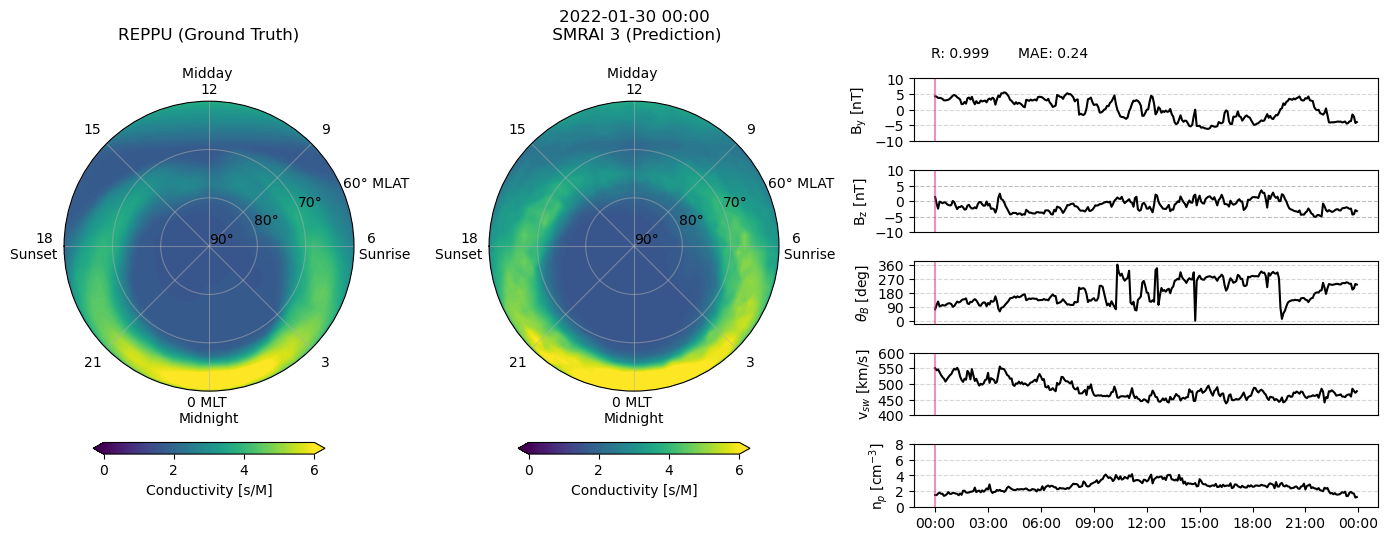

In [118]:
date = '2022-01-30'
#date = '2021-05-10'
time_plot = ds_pred.sel(dt=date)['dt']
times = ds_pred.sel(dt=date)['dt'].values
#remove the last time

#common paramters for ax1 (radar plot)
theta = np.linspace(0, 360, 80) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 30)

levels = np.linspace(-0.50, 0.50+0.01, 100)
shrink = 0.8
c_pad = 0.12
t_pad = 10

#current labels
ma = r'$\mathrm{\mu}$A/m$^{-2}$'
j_lab = r'J$_{||}$'
current_lab = f'FAC ({j_lab}) [{ma}]'


for i, time in enumerate(times):

    # Create a figure and GridSpec with 5 rows and 2 columns
    fig = plt.figure(figsize=(14, 5.5))
    
    gs = GridSpec(5, 3, width_ratios=[5, 5, 8])
    ax1 = fig.add_subplot(gs[:, 0], projection='polar') #make 1st column span all rows
    ax2 = fig.add_subplot(gs[:, 1], projection='polar') #make 1st column span all rows
    ax2_1 = fig.add_subplot(gs[0, 2])
    ax2_2 = fig.add_subplot(gs[1, 2], sharex=ax2_1)
    ax2_3 = fig.add_subplot(gs[2, 2], sharex=ax2_1)
    ax2_4 = fig.add_subplot(gs[3, 2], sharex=ax2_1)
    ax2_5 = fig.add_subplot(gs[4, 2], sharex=ax2_1)

    # ----------------- AX1 -----------------
    # ---------------------------------------
    t_pad = 20

    #Title
    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H:%M')
    ax1.set_title(f'\nREPPU (Ground Truth)', pad=t_pad)

    #get data and plot
    pot_levels = np.linspace(0, 6, 100)
    cond = ds_pred[target].sel(dt=date).values[i]
    ax1_contour = ax1.contourf(theta_rad, r, cond, levels=pot_levels, cmap='viridis', extend='both')

    #decoration
    ax1.set_ylim([0, 30])
    ax1.set_yticks([0, 10, 20, 30])
    ax1.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax1.grid(True, linestyle='-', alpha=0.5)

    ax1.set_xlim([-np.pi, np.pi])
    ax1.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax1.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    plt.colorbar(ax1_contour, ax=ax1, label=f'Conductivity [s/M]', shrink=shrink, pad=c_pad, 
          ticks=[0,2,4,6], orientation='horizontal')


    # ----------------- AX1 -----------------
    # ---------------------------------------
    t_pad = 20

    #Title
    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H:%M')
    ax2.set_title(f'{str_time}\n SMRAI 3 (Prediction)', pad=t_pad)

    #get data and plot
    pot_levels = np.linspace(0, 6, 100)
    pred_cond = ds_pred[f'{target}_pred'].sel(dt=date).values[i]
    #print(pred_cond.shape)
    ax2_contour = ax2.contourf(theta_rad, r, pred_cond, levels=pot_levels, cmap='viridis', extend='both')

    #decoration
    ax2.set_ylim([0, 30])
    ax2.set_yticks([0, 10, 20, 30])
    ax2.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax2.grid(True, linestyle='-', alpha=0.5)

    ax2.set_xlim([-np.pi, np.pi])
    ax2.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax2.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    plt.colorbar(ax2_contour, ax=ax2, label=f'Conductivity [s/M]', shrink=shrink, pad=c_pad, 
        ticks=[0,2,4,6], orientation='horizontal')
    
    #-------------- above AX2 --------------
    # ---------------------------------------
    MAE = np.mean(np.abs(cond - pred_cond))
    R = np.corrcoef(cond, pred_cond)[0,1]

    ax2_1.annotate(f'MAE: {MAE:.2f}', xy=(0.3, 1.4), xycoords='axes fraction', ha='center', va='center')
    ax2_1.annotate(f'R: {R:.3f}', xy=(0.1, 1.4), xycoords='axes fraction', ha='center', va='center')
    
    # ----------------- AX2.1 ---------------
    # ---------------------------------------
    ds_pred['BY_GSE'].sel(dt=date).plot(ax=ax2_1, color='k')
    ax2_1.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    By_lab = r'$\mathrm{B_y}$ [nT]'
    ax2_1.set_ylabel(By_lab)
    ax2_1.set_ylim([-10, 10])
    ax2_1.set_yticks([-10, -5, 0, 5, 10])
    ax2_1.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax2_1.xaxis.set_ticks_position('top')
    ax2_1.set_xlabel(' ')


    # ----------------- AX2.2 ---------------
    # ---------------------------------------
    ds_pred['BZ_GSE'].sel(dt=date).plot(ax=ax2_2, color='k')
    ax2_2.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    Bz_lab = r'$\mathrm{B_z}$ [nT]'
    ax2_2.set_ylabel(Bz_lab)
    ax2_2.set_ylim([-10, 10])
    ax2_2.set_yticks([-10, -5, 0, 5, 10])
    ax2_2.grid(True, linestyle='--', alpha=0.8)

    # ----------------- AX2.3 ---------------
    # ---------------------------------------
    ds_pred['clock_angle'].sel(dt=date).plot(ax=ax2_3, color='k')
    ax2_3.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    clock_angle_lab = r'$\theta_{B}$ [deg]'
    ax2_3.set_ylabel(f'{clock_angle_lab}')
    ax2_3.set_ylim([-20, 380])
    ax2_3.set_yticks([0, 90, 180, 270, 360])
    ax2_3.grid(True, linestyle='--', alpha=0.5)
    ax2_3.set_xlabel(' ')

    # ----------------- AX2.4 ---------------
    # ---------------------------------------
    ds_pred['flow_speed'].sel(dt=date).plot(ax=ax2_4, color='k')
    ax2_4.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    v_sw_lab = r'v$_{sw}$ [km/s]'
    ax2_4.set_ylabel(f'{v_sw_lab}')
    ax2_4.set_ylim([400, 600])
    ax2_4.set_yticks([400, 450, 500, 550, 600])
    ax2_4.grid(True, linestyle='--', alpha=0.5)


    #for i, val in enumerate(symh_hourly['Kp'].values):
    #plt.annotate(f'{val:.1f}', xy=((0.39+i)/8.8, -0.25), xycoords='axes fraction', ha='center', va='center')

    # ----------------- AX2.5 ---------------
    # ---------------------------------------
    ds_pred['proton_density'].sel(dt=date).plot(ax=ax2_5, color='k')
    ax2_5.axvline(time, color='#DC267F', linestyle='-', alpha=0.5)
    n_p_lab = r'n$_p$ [cm$^{-3}$]'
    ax2_5.set_ylabel(f'{n_p_lab}')
    ax2_5.set_ylim([0, 8])
    ax2_5.set_yticks([0, 2,4, 6,8])
    #ax2_5.grid(True, linestyle='--', alpha=0.5)
    ax2_5.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax2_5.set_xlabel(' ')
    
    #ax2_5.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    ax2_5.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))


    #add values to each of the x ticks on ax2_5
    kp = [1,2,3,4,5,6,7,8,9]

    #for i, val in enumerate(kp):
    #    plt.text(i, -7, f'{val}', color='k', ha='center', va='center', fontsize=10)

    '''
    annot_y = -0.5
    shift = 0.065
    ax2_5.annotate(f'Kp:', xy=(-0.05, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'2-', xy=(0.05+shift, annot_y), xycoords='axes fraction', ha='center', va='center') 
    ax2_5.annotate(f'1-', xy=(0.162+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'1+', xy=(0.275+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'3-', xy=(0.39+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'3', xy=(0.5+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'5+', xy=(0.61+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'5-', xy=(0.725+shift, annot_y), xycoords='axes fraction', ha='center', va='center')
    ax2_5.annotate(f'4-', xy=(0.84+shift, annot_y), xycoords='axes fraction', ha='center', va='center')'''

    #remove ticks
    for ax in [ax2_1, ax2_2, ax2_3, ax2_4]:
        ax.xaxis.set_visible(False)

    #remove top and right splines 
    #for ax in [ax2_1, ax2_2, ax2_3, ax2_4]:
    #    ax.spines['top'].set_visible(False)
    #    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    #plt.savefig(f'/home/sachin/Documents/NIPR/Research/Analysis/May-24/plots/potential/2022-01-30/conductivity_{mid}_{str_time}.png', dpi=300, bbox_inches='tight')
    #plt.savefig(f'/home/sachin/Documents/NIPR/Research/Analysis/June-24/plots/conductivity/2022-01-30/conductivity_{mid}_{str_time}.png', dpi=300, bbox_inches='tight')
    #plt.close()

    if i in [0]:
        break